## Introduction
This notebook demonstrates how to scale the CIFAR-10 image classification task using multiple FPGAs.
In the first step, we define the experiment configurations and create a config file.

### Define experiment parameters:

BATCH_SIZES => A list of different batch sizes (number of images) we would like to run this experiment for.

PLATFORM => One of the two supported platforms by the driver (alveo/zynq-iodma)

XCLBIN_PATH_DEFAULT => Default path for the .xclbin file if one not provided via command line args

DEVICE_NAME_DEFAULT => Default name for the FPGA device if one not provided via command line args

In [1]:
BATCH_SIZES = [20000] #,5000,10000,50000,100000]
# BATCH_SIZES = [1900000]
PLATFORM = "alveo"
XCLBIN_PATH_SINGLE = "bitstreams/a_u280.xclbin"
XCLBIN_PATH_DOUBLE = "bitstreams/a_u280_2cu.xclbin"
XCLBIN_PATH_QUAD = "bitstreams/a_u280_4cu.xclbin"
XCLBIN_PATH_OCTO = "bitstreams/a_u280_8cu.xclbin"
XCLBIN_PATH_DECA = "bitstreams/a_u280_10cu.xclbin"

DEVICE_NAME_DEFAULT = "xilinx_u280_xdma_201920_3"
XRT_ENV_PATH = "/opt/xilinx/xrt/setup.sh"
SPAWN_PATH = "/mnt/scratch/ldierick/octoray/cnv_w1a1_u280"

SPAWN_PATH = "/home/ldierick/octoray/cnv_w1a1_u280"

In [3]:
import json
cluster_config = {
    "scheduler":"10.1.212.126",
    "hosts":["10.1.212.126","10.1.212.127"], 
    "connect_options":{"port":22,"xrt":XRT_ENV_PATH,"dir":SPAWN_PATH},
    "worker_options":[{"nthreads":1,"n_workers":1,"preload":"pynqimport.py","nanny":"0","memory_limit":0},{"nthreads":1,"n_workers":2,"preload":"pynqimport.py","nanny":"0","memory_limit":0}],
    "scheduler_options":{"port":8786},
    "worker_class":"distributed.Worker",
    "overlay": [XCLBIN_PATH_SINGLE,XCLBIN_PATH_DOUBLE]
}

with open("cluster_config.json","w") as f:
    json.dump(cluster_config,f)



FileNotFoundError: [Errno 2] No such file or directory: '/mnt/scratch/ldierick/octoray/cnv_w1a1_u280/cluster_config.json'

### Download dataset
Download a numpy-array formatted CIFAR-10 dataset to the current directory:

In [3]:
!wget https://raw.githubusercontent.com/modestyachts/CIFAR-10.1/master/datasets/cifar10.1_v4_data.npy

--2022-05-05 14:45:02--  https://raw.githubusercontent.com/modestyachts/CIFAR-10.1/master/datasets/cifar10.1_v4_data.npy
Resolving proxy.ethz.ch (proxy.ethz.ch)... 129.132.202.155
Connecting to proxy.ethz.ch (proxy.ethz.ch)|129.132.202.155|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 6208640 (5.9M) [application/octet-stream]
Saving to: ‘cifar10.1_v4_data.npy.3’

cifar10.1_v4_data.n 100%[===================>]   5.92M  30.6MB/s    in 0.2s    

2022-05-05 14:45:02 (30.6 MB/s) - ‘cifar10.1_v4_data.npy.3’ saved [6208640/6208640]



### Define the worker method

Here, we define the Python method which will be executed on each of the Dask workers. This function calls the driver using the data partition it receives, and returns the output data (along with some performance statistics) to the caller (the Dask client)


In [3]:
def run_on_worker(ibuf_normal, kernel, index):
    import numpy as np
    import time
    from driver import FINNAccelDriver
    from pynq.ps import Clocks
    import os
    
    t0_total = time.time()

    batch_size = len(ibuf_normal) 
    device_name = kernel["device"]
    xclbin_path = kernel["path_to_bitstream"]

    
    finnDriver = FINNAccelDriver(batch_size, xclbin_path, platform=PLATFORM, device_name=device_name, kernel=kernel)
    ibuf_folded = finnDriver.fold_input(ibuf_normal)
    ibuf_packed = ibuf_folded
    finnDriver.copy_input_data_to_device(ibuf_packed)
    
    t0 = time.time()
    finnDriver.execute()
    t1 = time.time()
    
    obuf_packed = np.empty_like(finnDriver.obuf_packed_device)
    finnDriver.copy_output_data_from_device(obuf_packed)
    obuf_folded = finnDriver.unpack_output(obuf_packed)
    obuf_normal = finnDriver.unfold_output(obuf_folded)

    if PLATFORM != "alveo":
        fclk_mhz = Clocks.fclk0_mhz
    else:
        fclk_mhz = finnDriver.fclk_mhz
    runtime = t1-t0
    
    t1_total = time.time()


    return {
        'data': obuf_normal,
        'runtime': runtime,
        'index': index,
        'fclk_mhz': fclk_mhz,
        'throughput': batch_size/runtime,
        'bandwidth_in': np.prod(finnDriver.ishape_packed)*0.000001 / runtime,
        'bandwidth_out': np.prod(finnDriver.oshape_packed)*0.000001 / runtime,
        'N': batch_size

    }



### Run the experiment
Now we can run the classification.

1. Partition the dataset into as many parts as the number of workers
2. Send each part to a separate worker (using the *scatter* function from Dask)
3. Submit the *run_on_worker* defined above to the scheduler, which will run it on all the workers.
4. Collect and merge the results

In [ ]:
from dask.distributed import Client

client = Client("tcp://10.1.212.126:8786")
client.run_on_scheduler(lambda dask_scheduler=None: 
    dask_scheduler.close() & sys.exit(0))

In [ ]:
await octoray.fshutdown()

In [7]:
import time
import numpy as np
import json
from Octoray import Octoray

# Initialiaze octoray with automatic cluster deployment
octoray = Octoray(ssh_cluster=False, cluster_config=cluster_config)

# # set up the cluster
octoray.create_cluster()

Initializing OctoRay with client ip: 10.1.212.126
Waiting until workers are set up on remote machines...
Current amount of workers: 3


In [8]:
import time
import numpy as np
import json


# load dataset
full_cifar = np.load('cifar10.1_v4_data.npy')


#print(full_cifar.shape)
full_cifar = np.tile(full_cifar,[200,1,1,1])
print(full_cifar.shape)


execution_times = []
end_to_end_times = []

T = time.time()


for BATCH_SIZE in BATCH_SIZES:
    
    t0 = time.time()
    cnn_kernels = []
    
    # Both hosts execute a kernel with a single instance of the hardware design
    # for i in range(len(cluster_config["hosts"])):
    
    cnn_kernels.append(octoray.create_kernel(XCLBIN_PATH_SINGLE,1,int(BATCH_SIZE/octoray.num_of_workers),[[{"idma0":["DDR0"]},{"odma0":["DDR0"]}]],host="10.1.212.126", device=DEVICE_NAME_DEFAULT))

    cnn_kernels.append(octoray.create_kernel(XCLBIN_PATH_DOUBLE,2,int(BATCH_SIZE/(octoray.num_of_workers)), [[{"idma0":["HBM0"]},{"odma0":["HBM0"]}],[{"idma1":["HBM1"]},{"odma1":["HBM1"]}]],host="10.1.212.127", device=DEVICE_NAME_DEFAULT))
      

    # Set up the host's worker options based on the amount of instances in the kernel associated to it
    octoray.setup_worker_options()
    
    # In the case of multiple instances, subdivide the kernels over the number of instances
    kernels_split = octoray.split_kernels(cnn_kernels)
    
    # Divide the data set over the kernels based on batch size per instance
    data_split = octoray.split_data(full_cifar[:BATCH_SIZE],kernels_split)
    
    # Launch the tasks after scattering the data and kernels to the correct workers
    results = octoray.execute_hybrid(run_on_worker,data_split,kernels_split)

    # Reorder the response based on the original input order
    results.sort(key = lambda result: result['index'])  

    # Concatenate the result where each is an ndarray of the shape (BATCH_SIZE/num_of_workers, 1)
    merged_result = np.concatenate([r['data'] for r in results]) # FINAL RESULTS (CLASS LABELS)

    t1 = time.time()
    max_fpga_runtime = max([r['runtime'] for r in results])
    def avg(li):
        return sum(li)/len(li)

   
    print("TOTAL EXECUTION TIME:", t1-t0)
    print("Maximum FPGA runtime[s]:", max_fpga_runtime) # Shown in the plot
    print("Average throughput per node[images/s]:", avg([r['throughput'] for r in results]))
    print("Total throughput[image/s]:", BATCH_SIZE/ np.max([r['runtime'] for r in results]))
    print([r["runtime"] for r in results])
    print("Average DRAM_in_bandwidth[Mb/s]:", avg([r['bandwidth_in'] for r in results])) 
    print("Average DRAM_out_bandwidth[Mb/s]:", avg([r['bandwidth_out'] for r in results]))    
    print("**************************")   
    execution_times.append(max_fpga_runtime)
    end_to_end_times.append(t1-t0)

    
print(f"total time for all batches: {time.time()-T}")



(404200, 32, 32, 3)
TOTAL EXECUTION TIME: 2.654118776321411
Maximum FPGA runtime[s]: 2.1991751194000244
Average throughput per node[images/s]: 3037.2072633406333
Total throughput[image/s]: 9094.318966948102
[2.186051368713379, 2.1991751194000244, 2.1991641521453857]
Average DRAM_in_bandwidth[Mb/s]: 9.330300712982424
Average DRAM_out_bandwidth[Mb/s]: 0.0030372072633406337
**************************
total time for all batches: 2.6548211574554443


In [ ]:
await octoray.fshutdown()

### Generate a performance plot
Plot the execution times for different batch sizes. Here, we plot the maximum FPGA execution times from all the workers. This time includes the data buffering time to/from the FPGA and the actual inference time. To plot the total end-to-end time instead, replace the *execution_times* variable below with the *end_to_end_times* variable.

<Figure size 3600x3600 with 0 Axes>

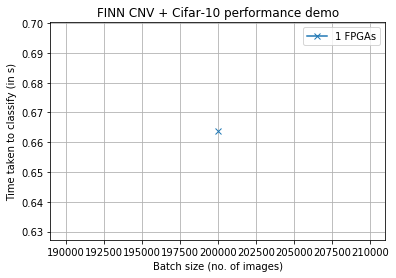

In [48]:
import numpy as np
import matplotlib.pyplot as plt
f = plt.figure(figsize=(50,50))
x = BATCH_SIZES[:3]
f = plt.figure()

y2 = execution_times
plt.plot(x, y2, label = "1 FPGAs", marker='x')

plt.xlabel('Batch size (no. of images)')
plt.ylabel('Time taken to classify (in s)')
plt.title('FINN CNV + Cifar-10 performance demo')

plt.legend()
plt.grid()

f.savefig("cnv-1-vs-2.png", bbox_inches='tight', dpi=150)

### Measure scaling benefits
To measure the benefits of scaling, run this notebook again after creating or destroying one or more Dask workers. Then compare the plots above to see the speedup.